In [1]:
#Loading libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil
import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle
import csv
from importlib import reload
import copy

import Utilities.Constants as Constants
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print("Successful!")

Successful!


In [2]:
Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Use_part_only":True,
               "Num_bins_for_calc":4,
               "Use_toys":True,
               "Num_toys":100,
               "Load_lepton_hists":False,
               "Load_pi0_hists":True,
               "Flat_bkg_overlay_frac":0.5,
               "Flat_bkg_dirt_frac":1.0,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.5,
               "Load_single_r1_file": False}

scaled = False #Just to keep track of if the histograms have been scaled

Functions.pyhf_params(Params_pyhf)

Using fully evaluated systematic uncertainty for background. Dirt will still be 100%.
Using fully evaluated systematic uncertainty for signal. Using 30.0% flux error.


In [3]:
hist_dict_run1, hist_dict_run3, theta_dict = Functions.Load_pyhf_files("FINAL_3.root", 
                                                                       Params_pyhf)#, HNL_masses = [245])


No missing histograms in Run1
thetas are:
{150: 1e-04, 180: 1e-04, 200: 1e-04, 220: 1e-04, 240: 1e-04, 245: 1e-04}
Done


## Loading in Uncertainties

In [4]:
def Calculate_total_uncertainty(Params, hist_dict, zero_bins_errs): #Takes the dictionary of all root files
    TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict = {}, {}
    BKG_STAT_ERR_dict, SIGNAL_STAT_ERR_dict = {}, {}
    BKG_SHAPESYS_ERR_dict, SIGNAL_SHAPESYS_ERR_dict = {}, {}
    SIGNAL_NORMSYS_ERR_dict = {} #No normsys for this because currently background contributions are added together
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    overlay_sys_names = ["ppfx_uncertainty","Genie_uncertainty","Reinteraction_uncertainty","overlay_DetVar_uncertainty"]
    for HNL_mass in hist_dict:
        bkg_stat_err_dict, bkg_sys_err_dict = {}, {} #Clean for each mass point
        for name in bkg_sample_names:
            bkg_stat_err_dict[name]=hist_dict[HNL_mass][name].errors() #Load in stat error from error saved in hist
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True: #Set all systematic errors to zero
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = np.zeros_like(hist_dict[HNL_mass][name].errors())
            sig_sys_err =  np.zeros_like(hist_dict[HNL_mass]['signal'].errors())
        elif Params["Use_flat_sys"] == True:
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = hist_dict[HNL_mass][name].values()*Params["Flat_"+name+"_frac"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_detvar_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_detvar"]
            sig_sys_err = np.sqrt(sig_flux_err**2 + sig_detvar_err**2)
        elif Params["Use_flat_sys"] == False: #This is using the fully evaluated uncertainties
            overlay_sys_dict = {}
            for sys in overlay_sys_names:
                overlay_sys_dict[sys] = hist_dict[HNL_mass][sys].values()
            bkg_sys_err_dict['bkg_overlay'] = Functions.add_all_errors_dict(overlay_sys_dict)
            bkg_sys_err_dict['bkg_EXT'] = np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors())
            bkg_sys_err_dict['bkg_dirt'] = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"]
            
            sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_sys_err = Functions.add_all_errors([sig_detvar_err,sig_flux_err])
            
        #Evaluating final stat+sys errors    
        bkg_stat_plus_sys_dict={}
        for name in bkg_sample_names:
            bkg_stat_plus_sys_dict[name]=Functions.add_all_errors([bkg_stat_err_dict[name],bkg_sys_err_dict[name],zero_bins_errs[HNL_mass][name]]) 
        
        total_bkg_err = Functions.add_all_errors_dict(bkg_stat_plus_sys_dict) #Now adding the errors of overlay, EXT and dirt in quadrature
        total_sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        
        TOT_BKG_ERR_dict[HNL_mass] = total_bkg_err
        TOT_SIGNAL_ERR_dict[HNL_mass] = total_sig_err
        
        BKG_STAT_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_stat_err_dict)
        BKG_SHAPESYS_ERR_dict[HNL_mass] = Functions.add_all_errors_dict(bkg_sys_err_dict)
        SIGNAL_STAT_ERR_dict[HNL_mass] = sig_stat_err
        SIGNAL_SHAPESYS_ERR_dict[HNL_mass] = sig_detvar_err
    TOT_ERR_DICT = {}
    TOT_ERR_DICT["TOT_BKG_ERR"], TOT_ERR_DICT["TOT_SIGNAL_ERR"] = TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    TOT_ERR_DICT["BKG_STAT"], TOT_ERR_DICT["BKG_SHAPESYS"] = BKG_STAT_ERR_dict, BKG_SHAPESYS_ERR_dict
    TOT_ERR_DICT["SIGNAL_STAT"], TOT_ERR_DICT["SIGNAL_SHAPESYS"] = SIGNAL_STAT_ERR_dict, SIGNAL_SHAPESYS_ERR_dict
    # return TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    return TOT_ERR_DICT
    

#Want TOTAL_BKG_ERR_DICT, STAT_BKG_ERR_DICT, SHAPESYS_BKG_ERR_DICT, where the shapesys also contains the dirt and overlay flat norm errors.
# TOTAL_SIGNAL_ERR_DICT, STAT_SIGNAL_ERR_DICT, SHAPESYS_SIGNAL_ERR_DICT, NORM_SIGNAL_ERR_DICT
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict

def add_data(Total_dict, hists, numbins):
    for HNL_mass in Total_dict:
        hist_placeholder = list(hists[HNL_mass]["data"].values())
        hist_data = Functions.remove_part_hist(hist_placeholder, numbins)
        Total_dict[HNL_mass]["data"]=hist_data
    return Total_dict

def add_data_appended(Total_dict, hists_r1, hists_r3, numbins):
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(hists_r1[HNL_mass]["data"].values())
        r3_hist_placeholder = list(hists_r3[HNL_mass]["data"].values())
        r1_hist = Functions.remove_part_hist(r1_hist_placeholder, numbins)
        r3_hist = Functions.remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist+r3_hist
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

In [5]:
reload(Functions)
zero_bins_errors_run1 = Functions.make_zero_bin_unc(hist_dict_run1, Constants.run1_POT_scaling_dict)
zero_bins_errors_run3 = Functions.make_zero_bin_unc(hist_dict_run3, Constants.run3_POT_scaling_dict)

TOT_R1_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run1, zero_bins_errors_run1)
TOT_R3_ERR = Calculate_total_uncertainty(Params_pyhf, hist_dict_run3, zero_bins_errors_run3)

R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3)

R1_output = Functions.Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, TOT_R1_ERR)
R3_output = Functions.Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, TOT_R3_ERR)

list_input_dicts = [R1_output, R3_output]

Total_dict_both = Functions.Create_final_appended_runs_dict(list_input_dicts)
Total_dict_run1 = Functions.Create_final_appended_runs_dict([R1_output])
Total_dict_run3 = Functions.Create_final_appended_runs_dict([R3_output])

if Params_pyhf["Use_part_only"]==True:
    NUMBINS = Params_pyhf["Num_bins_for_calc"]
else: NUMBINS=30 #This will just give the full hist
    
if 'data;1' in hist_dict_run1[150]:
    Total_dict_run1=add_data(Total_dict_run1, hist_dict_run1, NUMBINS)
    Total_dict_run3=add_data(Total_dict_run3, hist_dict_run3, NUMBINS)
    Total_dict_both=add_data_appended(Total_dict_both, hist_dict_run1, hist_dict_run3, NUMBINS)

dict_keys([150, 180, 200, 220, 240, 245])
dict_keys([150, 180, 200, 220, 240, 245])
dict_keys([150, 180, 200, 220, 240, 245])


In [6]:
def create_stat_unc(Total_dict):
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

sig_stat, bkg_stat = create_stat_unc(Total_dict_both)


In [7]:
def create_model_dict_same(Total_dict, debug=False): #Creating a model where the uncertainties are all enveloped in one shapesys modifier
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

def create_model_dict_split(Total_dict, debug=False): #Creating a model where the different types of uncertainties are split into different modifiers
    model_dict = {}
    sig_norm = {"hi": 1.0+Params_pyhf["Signal_flux_error"], "lo": 1.0-Params_pyhf["Signal_flux_error"]}
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['SIGNAL_SHAPESYS']},
                {"name": "stat_siguncrt", "type": "staterror", "data": sig_stat[HNL_mass]},  
                {"name": "norm_siguncrt", "type": "normsys", "data": sig_norm}  
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]['BKG_SHAPESYS']},
                {"name": "stat_bkguncrt", "type": "staterror", "data": bkg_stat[HNL_mass]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

## Scaling signal

In [8]:
def scale_signal(Total_dict, theta_dict, scaling_dict={}):
    """
    Scales the number of events by the number in the scaling dict.
    Returns the new dict of histograms and the new thetas.
    """
    if(scaling_dict=={}): raise Exception("Specify scalings")
    Total_dict_scaled, new_theta_dict = copy.deepcopy(Total_dict), {}
    for HNL_mass in Total_dict.keys():
        new_signal_hist = np.array(Total_dict[HNL_mass]['SIGNAL_dict'])*scaling_dict[HNL_mass]
        new_signal_err_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])*scaling_dict[HNL_mass]
        new_theta = theta_dict[HNL_mass]*scaling_dict[HNL_mass]**(1/4) # Number of events is proportional to theta**4
        
        Total_dict_scaled[HNL_mass]['SIGNAL_dict'] = list(new_signal_hist)
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_ERR'] = list(new_signal_err_hist)
        new_theta_dict[HNL_mass] = new_theta
        
    return Total_dict_scaled, new_theta_dict


In [9]:
single_SF = 2000
if Params_pyhf["Load_pi0_hists"]==False:
    scaling_dict = {2:5000,10:1000,20:2e9,50:5e6,100:1e5,150:5e3}
if Params_pyhf["Load_pi0_hists"]==True:
    scaling_dict = {150:100,180:10,200:5,220:2,240:2,245:2}
scaled=True

Total_dict, theta_dict_scaled  = scale_signal(Total_dict_both, theta_dict, scaling_dict)

In [10]:
print(Total_dict[150].keys())

dict_keys(['BKG_dict', 'SIGNAL_dict', 'TOT_BKG_ERR', 'TOT_SIGNAL_ERR', 'BKG_STAT', 'BKG_SHAPESYS', 'SIGNAL_STAT', 'SIGNAL_SHAPESYS', 'data'])


## Plotting example hist after scaling

In [ ]:
HNL_mass = 150
theta = theta_dict_scaled[HNL_mass]

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,4),facecolor='white',dpi=100)

num_bins = Params_pyhf["Num_bins_for_calc"]*2

bins = np.arange(0,num_bins+1,1)
bins_cents=(bins[:-1]+bins[1:])/2
plt.hist(bins_cents, weights=Total_dict[HNL_mass]['SIGNAL_dict'], bins=bins, histtype="step", lw=2, label=f"Signal \n" + fr"{HNL_mass}MeV $\theta$={theta:.5f}")
plt.hist(bins_cents, weights=Total_dict[HNL_mass]['BKG_dict'],bins=bins, histtype="step",lw=2, label="Background")

bkg_up=np.append((Total_dict[HNL_mass]['BKG_dict']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['BKG_dict']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
bkg_down=np.append((Total_dict[HNL_mass]['BKG_dict']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['BKG_dict']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
sig_up=np.append((Total_dict[HNL_mass]['SIGNAL_dict']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['SIGNAL_dict']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])
sig_down=np.append((Total_dict[HNL_mass]['SIGNAL_dict']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['SIGNAL_dict']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])

plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)

plt.yscale("log")
plt.legend()
plt.xlabel("BDT score")
plt.show()

## Creating model (only do once happy with scaling)

In [11]:
if scaled==False:
    print("Using unscaled hists")
    Total_dict, theta_dict_scaled = Total_dict_both, theta_dict

model_dict_both = create_model_dict_same(Total_dict)
# model_dict_split = create_model_dict_split(Total_dict_both)
# model_dict_run1 = create_model_dict_same(Total_dict_run1)
# model_dict_run3 = create_model_dict(Total_dict_run3)
print("Created models")

Created models


In [12]:
print(theta_dict_scaled)

{150: 0.00031622775802825267, 180: 0.00017782793651158064, 200: 0.0001495348743445533, 220: 0.00011892070849608224, 240: 0.00011892070849608224, 245: 0.00011892070849608224}


## Making uncertainty breakdown

In [ ]:
HNL_mass = 150
hist_dict_run3[HNL_mass].keys()

In [ ]:
# print(Total_dict[2].keys())
# print(Total_dict[2]['BKG_dict'])
# print(Total_dict[2]['BKG_ERR_dict'])

HNL_mass = 100
test_dict = {}
test_dict[HNL_mass] = hist_dict_run3[HNL_mass]

print("Signal:")
print(test_dict[HNL_mass]['signal'].values())
print("Background:")
print(test_dict[HNL_mass]['bkg_overlay'].values() + test_dict[HNL_mass]['bkg_EXT'].values() + test_dict[HNL_mass]['bkg_dirt'].values())
print()
print("Bkg overlay:")
print(test_dict[HNL_mass]['bkg_overlay'].values())
print("Bkg EXT:")
print(test_dict[HNL_mass]['bkg_EXT'].values())
print("Bkg dirt:")
print(test_dict[HNL_mass]['bkg_dirt'].values())
print()

TEST_BKG_ERR_dict, TEST_SIGNAL_ERR_dict = Functions.Uncertainty_breakdown(Params_pyhf, test_dict)

## Making test statistic plot

In [ ]:
model_dict = model_dict_both

HNL_mass = 10 #Mass point to test
DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict[HNL_mass].config.suggested_init()
model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

print(list(zip(model_dict[HNL_mass].config.parameters, init_pars)))
print(list(zip(model_dict[HNL_mass].config.parameters, bkg_pars)))

pdf_bkg = model_dict[HNL_mass].make_pdf(pyhf.tensorlib.astensor(bkg_pars)) #Making the pdfs
pdf_sig = model_dict[HNL_mass].make_pdf(pyhf.tensorlib.astensor(init_pars))

In [ ]:
n_samples = 500

# mu' = 0
mc_bkg = pdf_bkg.sample((n_samples,))
# mu' = 1
mc_sig = pdf_sig.sample((n_samples,))

print(mc_bkg.shape)
print(mc_sig.shape)

In [ ]:
toy_calculator_qtilde = pyhf.infer.utils.create_calculator( #only seems to support q-like test statistics
    "toybased",
    model_dict[HNL_mass].expected_data(init_pars),
    model_dict[HNL_mass],
    ntoys=n_samples,
    test_stat="qtilde",
)
qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0)

In [ ]:
print(max(qtilde_sig.samples))
print(max(qtilde_bkg.samples))

#Finding probability for one value of test statistic
ordered_test_stat = np.sort(qtilde_sig.samples)
length =len(ordered_test_stat)

prob = 0.9
slice_at = 0.9*length
print(np.floor(slice_at))
print(ordered_test_stat[int(slice_at)])
value_for_prob = ordered_test_stat[int(slice_at)]

In [ ]:
savefig=False

plt.figure(figsize=(14, 6))
nbins = 30 #Should make an array for the bin edges
bins = np.linspace(0,12,nbins) #was 0, 45 before
plt.hist(
    qtilde_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qtilde_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
)
# value_for_prob = 2.16

plt.axvline(x = value_for_prob, color = 'red', label = '90% exclusion',linestyle="dashed")

plt.xlabel(r"$\tilde{q}_1$", fontsize=22)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=22)

plt.yscale("log")
plt.legend(fontsize=22)

if savefig==True:
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_{HNL_mass}MeV.pdf")
    plt.savefig(f"plots/CLs_plots/Test_stat_qtilde_{HNL_mass}MeV.png")

In [ ]:
qmu_bounds = model_dict[HNL_mass].config.suggested_bounds()
print(f"Old bounds: {qmu_bounds}")
qmu_bounds[model_dict[HNL_mass].config.poi_index] = (-10, 10)
print(f"New bounds: {qmu_bounds}")


In [ ]:
toy_calculator_qmu = pyhf.infer.utils.create_calculator(
    "toybased",
    model_dict[HNL_mass].expected_data(model_dict[HNL_mass].config.suggested_init()),
    model_dict[HNL_mass],
    par_bounds=qmu_bounds,
    ntoys=n_samples,
    test_stat="q",
)
qmu_sig, qmu_bkg = toy_calculator_qmu.distributions(1.0)

In [ ]:
print(max(qmu_sig.samples))

In [ ]:
plt.figure(figsize=(14, 6))
nbins = 10 #Should make an array for the bin edges
bins = np.linspace(0,0.2,nbins)
plt.hist(
    qmu_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|1)$ signal-like",
    linewidth=2,
)
plt.hist(
    qmu_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label="$f(q_1|0)$ background-like",
    linewidth=2,
)
plt.xlabel(r"$q_1$", fontsize=18)
plt.ylabel(r"$f\,(q_1|\mu')$", fontsize=18)

plt.yscale("log")
plt.legend(fontsize=22)

## Testing single point

In [ ]:
# print(Total_dict_to_use[HNL_mass].keys())
# print(Total_dict_to_use[HNL_mass]["BKG_dict"])
# print(Total_dict_to_use[HNL_mass]["data"])
# print()

# print(Total_dict_to_use[HNL_mass]["BKG_dict"]+model_dict_to_use[HNL_mass].config.auxdata)
# print(Total_dict_to_use[HNL_mass]["data"]+model_dict_to_use[HNL_mass].config.auxdata)

In [13]:
HNL_mass = 150 #The mass point to test
n_sigmas = 2
if n_sigmas==1: sigma_list = np.arange(-1, 2)
if n_sigmas==2: sigma_list = np.arange(-2, 3)

model_dict_to_use = model_dict_both
Total_dict_to_use = Total_dict #Total_dict_both, Total_dict_run1, Total_dict_run3

DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict_to_use[HNL_mass].config.suggested_init()
model_dict_to_use[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict_to_use[HNL_mass].config.poi_index] = 0
model_dict_to_use[HNL_mass].expected_actualdata(bkg_pars) #bkg only

if 'data' not in Total_dict_to_use[HNL_mass].keys(): 
    print("No data in this sample, using bkg as data")
    DATA_OBS_dict[HNL_mass] = Total_dict_to_use[HNL_mass]["BKG_dict"]+model_dict_to_use[HNL_mass].config.auxdata
else: 
    print("Using real data for observed limit")
    DATA_OBS_dict[HNL_mass] = Total_dict_to_use[HNL_mass]["data"]+model_dict_to_use[HNL_mass].config.auxdata    

model_dict_to_use[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass]) #Is this only for the test stat distribution stuff?

if Params_pyhf["Use_toys"] == False:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
                1.0,  # null hypothesis
                DATA_OBS_dict[HNL_mass],
                model_dict_to_use[HNL_mass],
                test_stat="qtilde",
                return_expected_set=True,
                calctype="asymptotics",
                )
if Params_pyhf["Use_toys"] == True:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict_to_use[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            # track_progress=True, 
            # track_progress=False, #Used to have as true, but this gave an error when the signal was scaled up
            )

for expected_value, n_sigma in zip(CLs_exp, sigma_list): #-2, 3
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")
    
poi_values = np.linspace(0.001, 5, 500) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upperlimit(DATA_OBS_dict[HNL_mass], 
                                                                                       model_dict_to_use[HNL_mass], poi_values, 
                                                                                       level=0.1, return_results=True)
print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Using real data for observed limit


Background-like:  76%|██████████████████▏     | 76/100 [00:10<00:03,  7.09toy/s]/home/david/jupyter/envs/ana/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Expected CLs(-2 σ): 0.2557
Expected CLs(-1 σ): 0.3333
Expected CLs( 0 σ): 0.5151
Expected CLs( 1 σ): 1.0000
Expected CLs( 2 σ): 1.0000
Max value is 5.0
Min value is 0.001
Next value is 0.011018036072144289
Next value is 0.021036072144288577

Upper limit 150MeV (obs): μ = 2.6290
Upper limit 150MeV (exp): μ = 1.9873



In [14]:
exp_limit = []
obs_limit = []
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict_scaled[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

Expected 150MeV limit is 1.4097283201688547e-07
Observed 150MeV limit is 1.6214287357879552e-07



In [15]:
for HNL_mass in [HNL_mass]:
    theta_squared = (theta_dict_scaled[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta_squared)
    obs_limit.append(LIMIT)

Expected 150MeV limit is 1.4097283201688547e-07
Observed 150MeV limit is 1.6214287357879552e-07



In [ ]:
print(obs_limit)
print("Expected limit")
print(exp_limit)
print("1 sigma up")
print(exp_1sig_up)
print("2 sigma up")
print(exp_2sig_up)
print("1 sigma down")
print(exp_1sig_down)
print("2 sigma down")
print(exp_2sig_down)

In [ ]:
print(exp_limits_single)

## Running through all points

In [16]:
# model_dict = model_dict_split #Uncertainties are split into different modifiers, takes several times longer to run.
model_dict = model_dict_both #Quicker, uncertainties are entered as one uncertainty which is the quadsum of components.
Total_dict = Total_dict_both
if Params_pyhf["Load_pi0_hists"]==True:HNL_masses=Constants.HNL_mass_pi0_samples
if Params_pyhf["Load_pi0_hists"]==False:HNL_masses=Constants.HNL_mass_samples
    
# list_test = Constants.HNL_mass_samples
print("Running for these masses: " + str(HNL_masses))

DATA_OBS_dict = {}

for HNL_mass in HNL_masses:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[HNL_mass].keys())
    if "data" in list_keys: #haven't made this yet, need to test
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
    else:
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

Running for these masses: [150, 180, 200, 220, 240, 245]


In [17]:
#Takes ~10 mins with 100 toys and 4 bins, for all errors in one modifier
for HNL_mass in HNL_masses:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            # track_progress=True, 
            # track_progress=False, #Used to have as true, but this gave an error when the signal was scaled up
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

150MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0547
Expected CLs( 0 σ): 0.2234
Expected CLs( 1 σ): 1.0000
Expected CLs( 2 σ): 1.0000


180MeV
Expected CLs(-2 σ): 0.0280
Expected CLs(-1 σ): 0.1667
Expected CLs( 0 σ): 0.5959
Expected CLs( 1 σ): 1.0000
Expected CLs( 2 σ): 1.0000


200MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0784
Expected CLs( 0 σ): 0.1469
Expected CLs( 1 σ): 0.4412
Expected CLs( 2 σ): 1.0000


220MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0940
Expected CLs( 0 σ): 0.1901
Expected CLs( 1 σ): 1.0000
Expected CLs( 2 σ): 1.0000


240MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.3131
Expected CLs( 1 σ): 0.4984
Expected CLs( 2 σ): 1.0000


245MeV
Expected CLs(-2 σ): 0.0482
Expected CLs(-1 σ): 0.1141
Expected CLs( 0 σ): 0.3299
Expected CLs( 1 σ): 0.4435
Expected CLs( 2 σ): 1.0000


In [18]:
#Should take ~10 mins with 100 toys and 4 bins
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 5, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in HNL_masses:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Max value is 5.0
Min value is 0.001
Next value is 0.05149494949494949
Next value is 0.10198989898989898

Upper limit 150MeV (obs): μ = 2.629081
Upper limit 150MeV (exp): μ = 1.987707

Upper limit 180MeV (obs): μ = 2.361425
Upper limit 180MeV (exp): μ = 2.053394

Upper limit 200MeV (obs): μ = 2.722459
Upper limit 200MeV (exp): μ = 1.782090

Upper limit 220MeV (obs): μ = 2.805988
Upper limit 220MeV (exp): μ = 2.096015

Upper limit 240MeV (obs): μ = 1.721096
Upper limit 240MeV (exp): μ = 1.650219

Upper limit 245MeV (obs): μ = 1.557029
Upper limit 245MeV (exp): μ = 1.353076



In [ ]:
# print((scan, results))
# print(scan)
# print(results[90])

In [19]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict_scaled[HNL_mass])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
    obs_limit.append(LIMIT)
    
print(exp_limit)
print(obs_limit)
removed_2MeV = False

9.999999494757512e-08
Expected 150MeV limit is 1.4098606853305157e-07
Observed 150MeV limit is 1.6214441171748107e-07

3.162277500396675e-08
Expected 180MeV limit is 4.531439080589466e-08
Observed 180MeV limit is 4.859448871790554e-08

2.2360678645241344e-08
Expected 200MeV limit is 2.98503794161764e-08
Observed 200MeV limit is 3.689484143218274e-08

1.4142134909210168e-08
Expected 220MeV limit is 2.0474446517018828e-08
Observed 220MeV limit is 2.3689609806454802e-08

1.4142134909210168e-08
Expected 240MeV limit is 1.8167105050606288e-08
Observed 240MeV limit is 1.855314677579806e-08

1.4142134909210168e-08
Expected 245MeV limit is 1.6450382356038138e-08
Observed 245MeV limit is 1.7646694098463687e-08

[1.4098606853305157e-07, 4.531439080589466e-08, 2.98503794161764e-08, 2.0474446517018828e-08, 1.8167105050606288e-08, 1.6450382356038138e-08]
[1.6214441171748107e-07, 4.859448871790554e-08, 3.689484143218274e-08, 2.3689609806454802e-08, 1.855314677579806e-08, 1.7646694098463687e-08]


## Removing 2MeV point

In [20]:
reload(Constants)
if Params_pyhf["Load_lepton_hists"]==True:
    HNL_masses=Constants.HNL_mass_samples.copy()
    if removed_2MeV == False:
        print("Removing the first element in the limit and mass lists")
        exp_limit.pop(0)
        obs_limit.pop(0)
        HNL_masses.pop(0)
        exp_1sig_up.pop(0)
        exp_2sig_up.pop(0)
        exp_1sig_down.pop(0)
        exp_2sig_down.pop(0)
        print(HNL_masses)
        print(exp_limit)
        print(obs_limit)
    else: print("First element has already been removed")
    removed_2MeV = True

## Saving limit as .csv

In [21]:
masses = HNL_masses

if Params_pyhf["Stats_only"] == True: stats =  "Stats_only"
elif Params_pyhf["Use_flat_sys"] == True: stats = "Flat_sys"
else: stats = "Full_sys"
    
if Params_pyhf["Use_part_only"] == True: part_hist = str(Params_pyhf["Num_bins_for_calc"])+"_bins"
else: part_hist = "full_hist"

print(masses)
print(exp_limit)

filename = "observed_21_April.csv"

# r = zip(masses, exp_limit)
r = zip(masses, obs_limit)
if Params_pyhf["Load_pi0_hists"] == False:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
if Params_pyhf["Load_pi0_hists"] == True:
    savename = f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}'
    with open(f'limit_files/My_limits/{stats}_{part_hist}_pi0_{filename}', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print()
print("Save name is : \'"+savename+"\'")

[150, 180, 200, 220, 240, 245]
[1.4098606853305157e-07, 4.531439080589466e-08, 2.98503794161764e-08, 2.0474446517018828e-08, 1.8167105050606288e-08, 1.6450382356038138e-08]

Save name is : 'limit_files/My_limits/Full_sys_4_bins_pi0_observed_21_April.csv'


## Saving sigma bands for brazil plots

In [22]:
save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

if Params_pyhf["Load_lepton_hists"] == True:decay_type = "ee"
if Params_pyhf["Load_pi0_hists"]==True: decay_type = "pi0"

filename=f"_{decay_type}_21_April.csv"
for i, lim in enumerate(to_save_lists):

    r = zip(masses, lim)
    savestr=to_save_names[i]
    savename = save_loc+savestr+filename
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print("Last saved is " + savename)

Last saved is limit_files/Brazil_plot/obs_limit_pi0_21_April.csv


## Testing adjacent models

In [ ]:
adjacent_hist_dict_run1, adjacent_hist_dict_run3 = {}, {}
R1_BKG_ERR_dict_ADJ, R3_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = {}, {}, {}, {}
mass_point = 50
test_models = [20, 100]
for mass_model in test_models:
    adjacent_hist_dict_run1[mass_model] = uproot.open(f'bdt_output/adjacent_models/run1_{mass_point}MeV_{mass_model}MeV_model.root')
    adjacent_hist_dict_run3[mass_model] = uproot.open(f'bdt_output/adjacent_models/run3_{mass_point}MeV_{mass_model}MeV_model.root')
    R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run1)
    R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run3)
    # R1_BKG_ERR_dict_ADJ[mass_model]=R1_BKG_ERR_dict[mass_point]
    # R3_BKG_ERR_dict_ADJ[mass_model]=R3_BKG_ERR_dict[mass_point]
    # R1_SIGNAL_ERR_dict_ADJ[mass_model]=R1_SIGNAL_ERR_dict[mass_point]
    # R3_SIGNAL_ERR_dict_ADJ[mass_model]=R3_SIGNAL_ERR_dict[mass_point]
adjacent_hist_dict_run1[mass_point] = hist_dict_run1[mass_point]
adjacent_hist_dict_run3[mass_point] = hist_dict_run3[mass_point]
R1_BKG_ERR_dict_ADJ[mass_point]=R1_BKG_ERR_dict[mass_point]
R3_BKG_ERR_dict_ADJ[mass_point]=R3_BKG_ERR_dict[mass_point]
R1_SIGNAL_ERR_dict_ADJ[mass_point]=R1_SIGNAL_ERR_dict[mass_point]
R3_SIGNAL_ERR_dict_ADJ[mass_point]=R3_SIGNAL_ERR_dict[mass_point]

R1_BKG_ADJ, R1_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run1)
R3_BKG_ADJ, R3_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run3)

R1_output_ADJ = Functions.Make_into_lists(Params_pyhf, R1_BKG_ADJ, R1_SIGNAL_ADJ, R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ)
R3_output_ADJ = Functions.Make_into_lists(Params_pyhf, R3_BKG_ADJ, R3_SIGNAL_ADJ, R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ)

list_input_dicts_ADJ = [R1_output_ADJ, R3_output_ADJ]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict_ADJ = Functions.Create_final_appended_runs_dict(list_input_dicts_ADJ)
print(Total_dict_ADJ[100].keys())

In [ ]:
print(Total_dict.keys())

In [ ]:
model_dict_ADJ = create_model_dict(Total_dict_ADJ)

In [ ]:
list_test = adjacent_hist_dict_run1.keys()
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

In [ ]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict_scaled[mass_point])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

In [ ]:
points = [6.912810521978472e-06, 7.3827958770328454e-06, 1.9840221581842897e-05]
x_points = [50, 50, 50]
labels = ["correct", "20MeV", "50MeV"]
for i, point in enumerate(points):
    plt.plot(x_points[i],point,label=labels[i],marker="o")
plt.legend()

In [ ]:
rat_20 = 6.912810521978472e-06/7.3827958770328454e-06
rat_100 = 6.912810521978472e-06/1.9840221581842897e-05
print("20MeV model is " + str(rat_20))
print("100MeV model is " + str(rat_100))

## Brazil plot

In [ ]:
#Plotting ee limit
if Params_pyhf["Load_pi0_hists"]==False:
    plt.figure(figsize=(14,8),facecolor='white',dpi=100)

    savefig = True

    plt.plot(HNL_masses,np.array(obs_limit),lw=4,ls='-',color='black',label='Observed')
    plt.plot(HNL_masses,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
    plt.fill_between(HNL_masses,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
    plt.fill_between(HNL_masses,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')

    plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
    plt.xlabel('HNL Mass [MeV]',fontsize=22)

    plt.ylim(5e-7,6e-3)
    plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlim(0,155)
    # plt.xlim(0,250)
    plt.yscale('log')

    plt.tight_layout()

    savename = "ee_observed"

    if savefig == True:
        plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

    plt.grid(False)


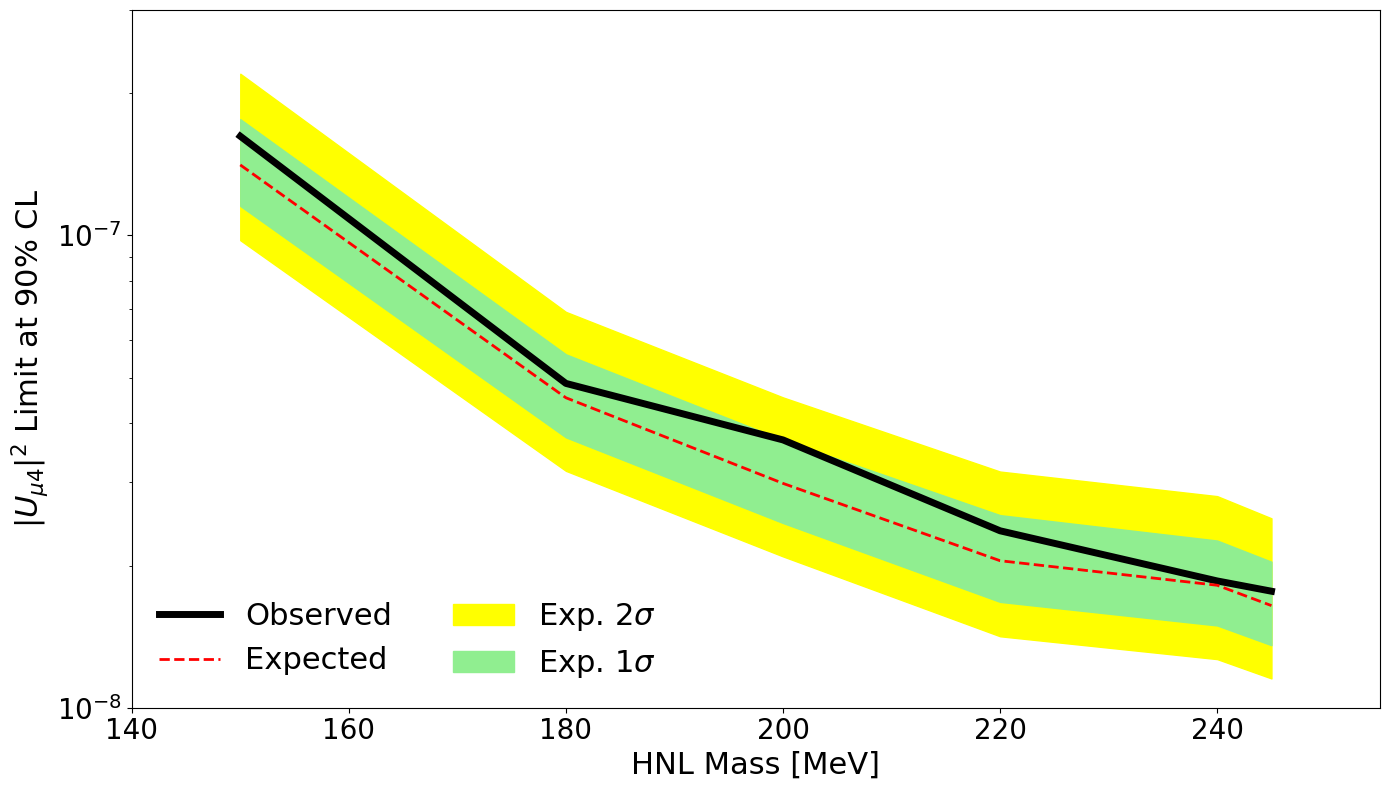

In [49]:
#Plotting pi0 limit
if Params_pyhf["Load_pi0_hists"]==True:
    plt.figure(figsize=(14,8),facecolor='white',dpi=100)

    savefig = True

    plt.plot(HNL_masses,np.array(obs_limit),lw=5,ls='-',color='black',label='Observed')
    plt.plot(HNL_masses,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
    plt.fill_between(HNL_masses,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
    plt.fill_between(HNL_masses,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')

    plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
    plt.xlabel('HNL Mass [MeV]',fontsize=22)

    plt.ylim(1e-8,3e-7)
    plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlim(140,255)
    # plt.xlim(0,250)
    plt.yscale('log')

    plt.tight_layout()

    savename = "pi0_observed"

    if savefig == True:
        plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

    plt.grid(False)

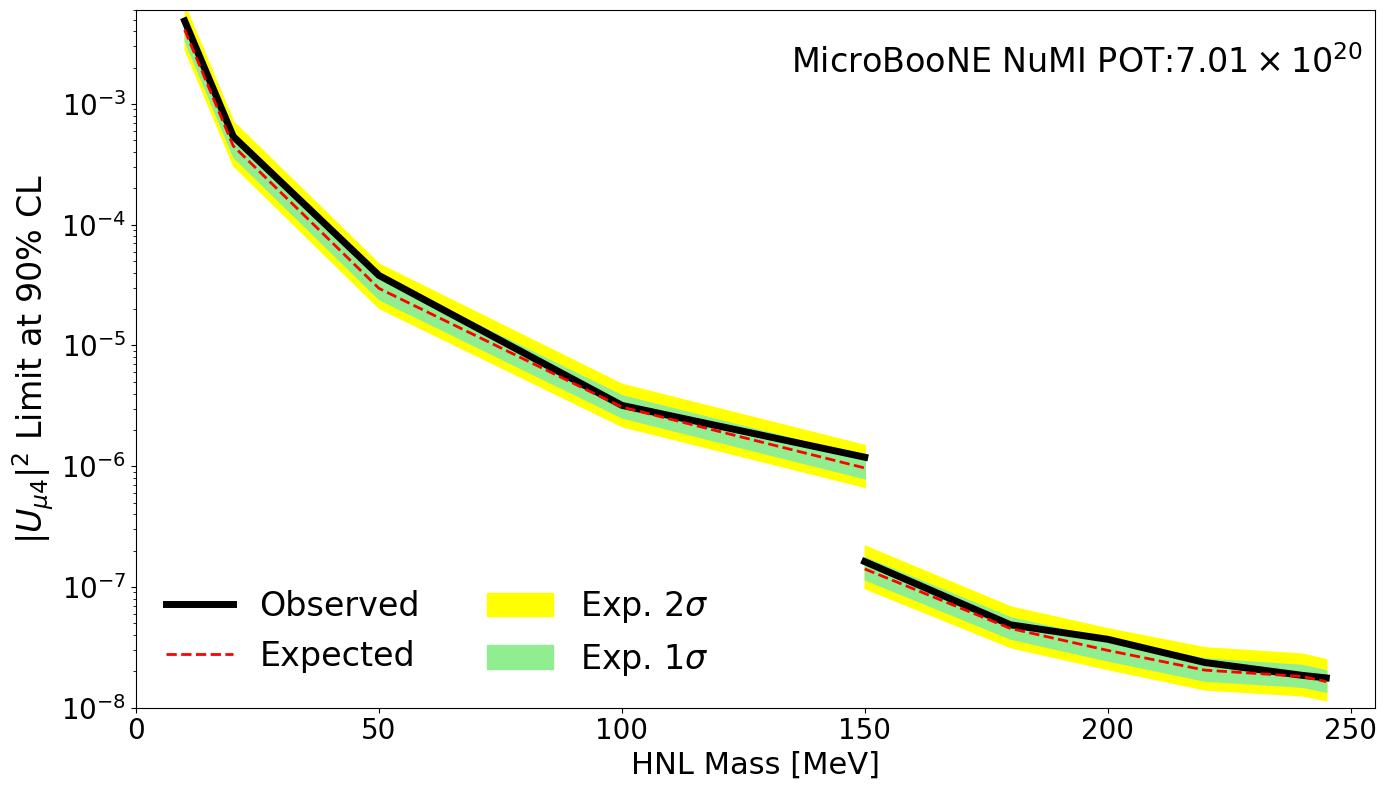

In [48]:
#Plotting BOTH on one plot
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = False

save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

#ee curves
decay_type="ee"
filename=f"_{decay_type}_21_April.csv"
# for i, lim in enumerate(to_save_lists):

ee_exp_1sig_up = Functions.Pandafy_new(save_loc+"exp_1sig_up"+filename)
ee_exp_1sig_down = Functions.Pandafy_new(save_loc+"exp_1sig_down"+filename)
ee_exp_2sig_up = Functions.Pandafy_new(save_loc+"exp_2sig_up"+filename)
ee_exp_2sig_down = Functions.Pandafy_new(save_loc+"exp_2sig_down"+filename)
ee_exp_limit = Functions.Pandafy_new(save_loc+"exp_limit"+filename)
ee_obs_limit = Functions.Pandafy_new(save_loc+"obs_limit"+filename)
HNL_masses_ee = [10, 20, 50, 100, 150]

plt.plot(HNL_masses_ee,np.array(ee_obs_limit["Value"]),lw=5,ls='-',color='black')
plt.plot(HNL_masses_ee,np.array(ee_exp_limit["Value"]),lw=2,ls='--',color='red')
plt.fill_between(HNL_masses_ee,np.array(ee_exp_2sig_down["Value"]),np.array(ee_exp_2sig_up["Value"]),color='yellow')
plt.fill_between(HNL_masses_ee,np.array(ee_exp_1sig_down["Value"]),np.array(ee_exp_1sig_up["Value"]),color='lightgreen')

#pi0 curves
decay_type="pi0"
filename=f"_{decay_type}_21_April.csv"
HNL_masses_pi0 = [150, 180, 200, 220, 240, 245]

pi0_exp_1sig_up = Functions.Pandafy_new(save_loc+"exp_1sig_up"+filename)
pi0_exp_1sig_down = Functions.Pandafy_new(save_loc+"exp_1sig_down"+filename)
pi0_exp_2sig_up = Functions.Pandafy_new(save_loc+"exp_2sig_up"+filename)
pi0_exp_2sig_down = Functions.Pandafy_new(save_loc+"exp_2sig_down"+filename)
pi0_exp_limit = Functions.Pandafy_new(save_loc+"exp_limit"+filename)
pi0_obs_limit = Functions.Pandafy_new(save_loc+"obs_limit"+filename)


plt.plot(HNL_masses_pi0,np.array(pi0_obs_limit["Value"]),lw=5,ls='-',color='black',label='Observed')
plt.plot(HNL_masses_pi0,np.array(pi0_exp_limit["Value"]),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HNL_masses_pi0,np.array(pi0_exp_2sig_down["Value"]),np.array(pi0_exp_2sig_up["Value"]),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HNL_masses_pi0,np.array(pi0_exp_1sig_down["Value"]),np.array(pi0_exp_1sig_up["Value"]),color='lightgreen',label=r'Exp. 1$\sigma$')


plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=24)
plt.xlabel('HNL Mass [MeV]',fontsize=22)

plt.ylim(1e-8,6e-3)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=24)
plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=24,color='black',alpha=1,
         verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(0,255)
# plt.xlim(0,250)
plt.yscale('log')

plt.tight_layout()

savename = "Both_channels_observed"

# plt.grid(True,lw=1, alpha=0.3)

if savefig == True:
    plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
    plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)


## Dumping model example

In [ ]:
HNL_mass = 100
print(json.dumps(model_dict[HNL_mass].spec, indent=2))

# End of code